# Meanshift和Camshift

### 学习目标

在本章中，
- 我们将学习用于跟踪视频中对象的Meanshift和Camshift算法。
 
### Meanshift

Meanshift背后的直觉很简单，假设你有点的集合。（它可以是像素分布，例如直方图反投影）。你会得到一个小窗口（可能是一个圆形），并且必须将该窗口移到最大像素密度（或最大点数）的区域。如下图所示：

![](data/meanshift_basics.jpg)

初始窗口以蓝色圆圈显示，名称为“C1”。其原始中心以蓝色矩形标记，名称为“C1_o”。但是，如果找到该窗口内点的质心，则会得到点“C1_r”（标记为蓝色小圆圈），它是窗口的真实质心。当然，它们不匹配。因此，移动窗口，使新窗口的圆与上一个质心匹配。再次找到新的质心。很可能不会匹配。因此，再次移动它，并继续迭代，以使窗口的中心及其质心落在同一位置（或在很小的期望误差内）。因此，最终您获得的是一个具有最大像素分布的窗口。它带有一个绿色圆圈，名为“C2”。正如您在图像中看到的，它具有最大的点数。整个过程在下面的静态图像上演示：

![](data/camshift_face.gif)

因此，我们通常会传递直方图反投影图像和初始目标位置。当对象移动时，显然该移动会反映在直方图反投影图像中。结果，meanshift算法将窗口移动到最大密度的新位置。

### OpenCV中的Meanshift

要在OpenCV中使用meanshift，首先我们需要设置目标，找到其直方图，以便我们可以将目标反投影到每帧上以计算均值偏移。我们还需要提供窗口的初始位置。对于直方图，此处仅考虑色相。另外，为避免由于光线不足而产生错误的值，可以使用**cv.inRange**()函数丢弃光线不足的值。

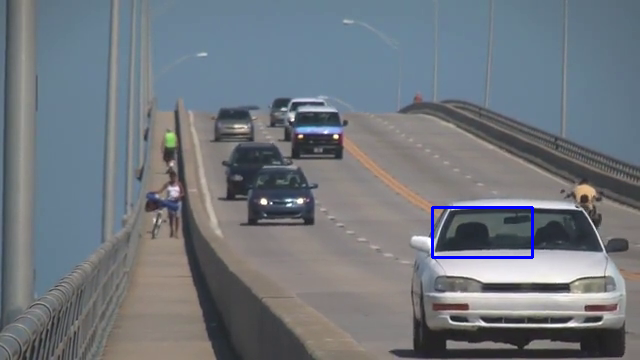

In [1]:
import numpy as np
import cv2 as cv
from IPython.display import clear_output, display, HTML
from PIL import Image
import time

cap = cv.VideoCapture('data/slow_traffic_small.mp4')

# 视频的第一帧
ret,frame = cap.read()

# 设置窗口的初始位置
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)

# 设置初始ROI来追踪
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)

mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# 设置终止条件，可以是10次迭代，也可以至少移动1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    clear_output(wait=True)

    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # 应用meanshift来获取新位置
        ret, track_window = cv.meanShift(dst, track_window, term_crit)

        # 在图像上绘制
        x,y,w,h = track_window

        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
        
        img = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        display(img)

        if cap.get(cv.CAP_PROP_POS_FRAMES) > 133:
            break

        # 控制帧率
        time.sleep(0.033)
    else:
        break

cap.release()

## Camshift

您是否密切关注了最后结果？这儿存在一个问题。无论汽车离相机很近或非常近，我们的窗口始终具有相同的大小。这是不好的。我们需要根据目标的大小和旋转来调整窗口大小。该解决方案再次来自“ OpenCV Labs”，它被称为Gary布拉德斯基（Gary Bradsky）在其1998年的论文“用于感知用户界面中的计算机视觉面部跟踪”中发表的CAMshift（连续自适应均值偏移）[26]。
它首先应用Meanshift。一旦Meanshift收敛，它将更新窗口的大小为`s = 2 \times \sqrt{\frac{M_{00}}{256}}`。它还可以计算出最合适的椭圆的方向。再次将均值偏移应用于新的缩放搜索窗口和先前的窗口位置。该过程一直持续到达到要求的精度为止。

![camshift_face](data/camshift_face.gif)

### OpenCV中的Camshift

它与meanshift相似，但是返回一个旋转的矩形（即我们的结果）和box参数（用于在下一次迭代中作为搜索窗口传递）。请参见下面的代码：

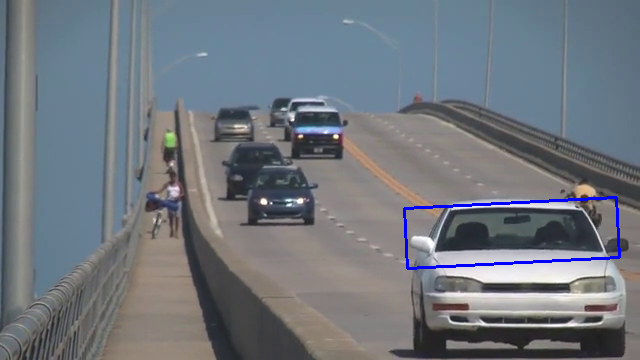

In [2]:
import numpy as np
import cv2 as cv
from IPython.display import clear_output, display, HTML
from PIL import Image
import time

cap = cv.VideoCapture('data/slow_traffic_small.mp4')

# 视频的第一帧
ret,frame = cap.read()

# 设置窗口的初始位置
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)

# 设置初始ROI来追踪
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)

mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# 设置终止条件，可以是10次迭代，也可以至少移动1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    clear_output(wait=True)

    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # 应用camshift 到新位置
        ret, track_window = cv.CamShift(dst, track_window, term_crit)

        # 在图像上画出来
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, (255,0,0),2)
        
        img = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        display(img)

        if cap.get(cv.CAP_PROP_POS_FRAMES) > 133:
            break

        # 控制帧率
        time.sleep(0.033)
    else:
        break

cap.release()

### 附加资源

1. French Wikipedia page on Camshift:http://fr.wikipedia.org/wiki/Camshift. (The two animations are taken from there)
2. Bradski, G.R., "Real time face and object tracking as a component of a perceptual user interface," Applications of Computer Vision, 1998. WACV '98. Proceedings., Fourth IEEE Workshop on , vol., no., pp.214,219, 19-21 Oct 1998

## Exercises

1. OpenCV comes with a Python :https://github.com/opencv/opencv/blob/master/samples/python/camshift.py for an interactive demo of camshift. Use it, hack it, understand it.